# PyTorch Fundamentals – Binary Classification (Circles Dataset)

## Objective

This notebook demonstrates core PyTorch fundamentals by solving a **binary classification** problem using a synthetic (toy) dataset.
The focus is on:

* Dataset preparation
* Model definition
* Training & evaluation loops
* Non-linearity and decision boundaries


## 1. Imports & Setup

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [2]:
# Device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2. Dataset Creation & Exploration

In [3]:
# Create a non-linear binary classification dataset
X, y = make_circles(
    n_samples=1000,
    noise=0.03,
    random_state=42
)

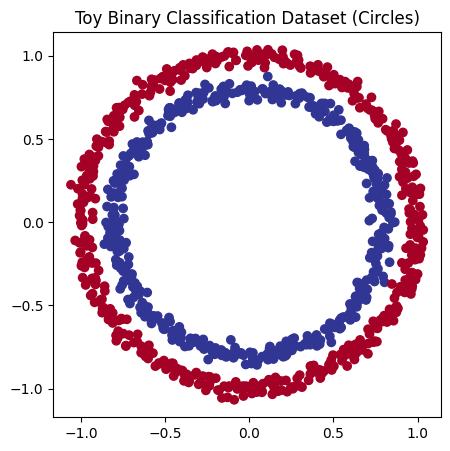

In [4]:
# Visualize dataset
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.title("Toy Binary Classification Dataset (Circles)")
plt.savefig("../images/Toy_Binary_Classification_Dataset_Circles.png")
plt.show()

## 3. Train/Test Split & Tensor Conversion

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [7]:
# Move tensors to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

## 4. Model Definition

We use a simple **feed-forward neural network** with non-linear activation functions.


In [8]:
# Build a model with non-linear activation functions
class CircleModelV1(nn.Module):
    def __init__(self, input_features,hidden_features ,output_features):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_features)
        self.layer_2 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.layer_3 = nn.Linear(in_features=hidden_features, out_features=output_features)
        self.relu = nn.ReLU() # relu is non-linear activation function

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModelV1(input_features=2,
                        hidden_features=16,
                        output_features=1).to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

## 5. Loss Function & Optimizer

For binary classification, we use **BCEWithLogitsLoss**, which internally applies the sigmoid function.

In [9]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.01)

## 6. Helper Functions (Accuracy & Decision Boundry)

In [10]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [15]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor, save_path=None):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")

## 7. Training & Evaluation Loop

In [12]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Loop though data
epochs = 100

for epoch in range(epochs):
    # Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred prob -> prediction labels

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what`s happening !!!
    if epoch % 5 == 0:
        print(f'Epochs: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%')

Epochs: 0 | Loss: 0.69193 | Acc: 51.00% | Test loss: 0.6896, Test acc: 54.50%
Epochs: 5 | Loss: 0.68408 | Acc: 55.00% | Test loss: 0.6822, Test acc: 58.50%
Epochs: 10 | Loss: 0.67205 | Acc: 62.00% | Test loss: 0.6715, Test acc: 66.50%
Epochs: 15 | Loss: 0.65327 | Acc: 65.50% | Test loss: 0.6564, Test acc: 61.50%
Epochs: 20 | Loss: 0.62631 | Acc: 66.25% | Test loss: 0.6334, Test acc: 69.50%
Epochs: 25 | Loss: 0.58925 | Acc: 87.62% | Test loss: 0.5990, Test acc: 88.50%
Epochs: 30 | Loss: 0.54101 | Acc: 91.62% | Test loss: 0.5539, Test acc: 90.50%
Epochs: 35 | Loss: 0.48109 | Acc: 94.38% | Test loss: 0.4957, Test acc: 93.50%
Epochs: 40 | Loss: 0.41168 | Acc: 98.88% | Test loss: 0.4291, Test acc: 97.50%
Epochs: 45 | Loss: 0.33669 | Acc: 99.62% | Test loss: 0.3593, Test acc: 99.00%
Epochs: 50 | Loss: 0.26558 | Acc: 99.88% | Test loss: 0.2939, Test acc: 100.00%
Epochs: 55 | Loss: 0.20237 | Acc: 99.88% | Test loss: 0.2330, Test acc: 100.00%
Epochs: 60 | Loss: 0.15125 | Acc: 100.00% | Test los

## 8. Model Evaluation & Visualization

In [13]:
model_1.eval()
with torch.inference_mode():
    y_test_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()

Plot saved to ../images/Decision_boundaries.png
Plot saved to ../images/Decision_boundaries.png


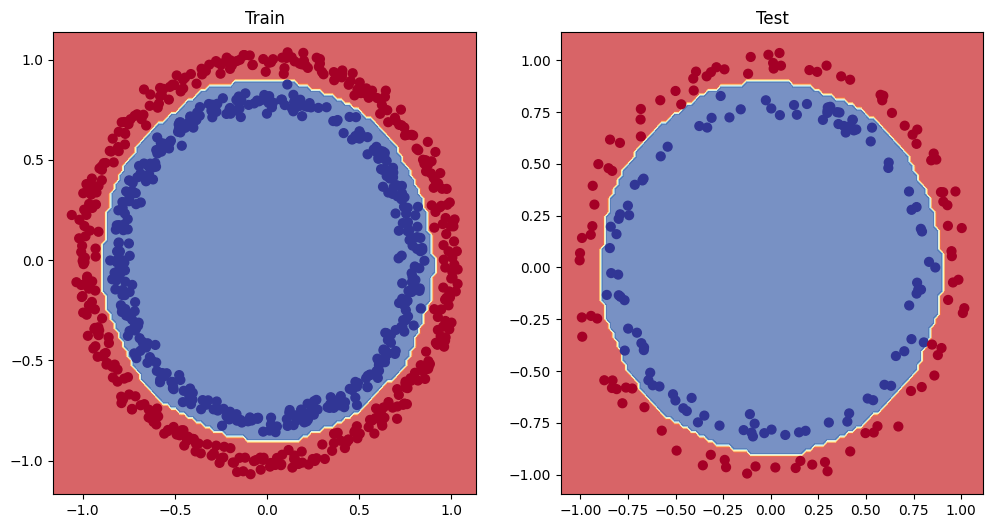

In [17]:
# Plot decision bounaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train,save_path="../images/Decision_boundaries.png")
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test,save_path="../images/Decision_boundaries.png")

## 9. Conclusion

* Linear models fail on this dataset due to non-linearity
* Adding **ReLU activations** enables the network to learn complex decision boundaries
* This notebook demonstrates a complete **PyTorch training workflow** from scratch